In [1]:
import os
import pickle
import logging

import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import MixedEffects
from constants import (
    DATA_PATH,
    TOML_PATH,
    INFERENCE_FILE,
    NETCODE_FILE,
    BUILD_DIR
)

logger = logging.getLogger(__name__)
setup_logging(dir=BUILD_DIR, fname="figure")


2024-03-08 16:59:39,520 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/figure.log


In [2]:
M = MixedEffects

# Load posterior
dest = os.path.join(BUILD_DIR, M.NAME, INFERENCE_FILE)
with open(dest, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)

posterior_samples = posterior_samples_.copy()
posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Load data
df = pd.read_csv(DATA_PATH)
ind = ~df[model.response].isna().values.any(axis=-1)
df = df[ind].reset_index(drop=True).copy()
df[model.features[1]] = df[model.features[1]].replace({"L": "01_L", "M": "02_M"})
df, encoder_dict = model.load(df=df)


2024-03-08 16:59:39,670 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-03-08 16:59:39,671 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-03-08 16:59:39,672 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-03-08 16:59:40,627 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/mixed_effects
2024-03-08 16:59:40,631 - hbmep.dataset.core - INFO - Processing data ...
2024-03-08 16:59:40,633 - hbmep.utils.utils - INFO - func:load took: 0.01 sec


In [3]:
subset = [(7, 0), (7, 1), (12, 0), (12, 1)]
ind = df[model.features].apply(tuple, axis=1).isin(subset)
df = df[ind].reset_index(drop=True).copy()


In [4]:
prediction_df = model.make_prediction_dataset(df=df, num_points=5000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


2024-03-08 16:59:42,324 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2024-03-08 17:03:20,444 - hbmep.utils.utils - INFO - func:predict took: 3 min and 38.12 sec


In [5]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)
mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)
a_random_mean = posterior_samples["a_random_mean"]


In [6]:
# Plot aesthetics
response_colors = {
    0: {
        0: (0.6706, 0.8510, 0.9137),
        1: (0.9451, 0.7137, 0.8549),
        2: (0.7216, 0.8824, 0.5255)
    },
    1: {
        0: (0.1725, 0.4824, 0.7137),
        1: (0.8157, 0.1098, 0.5451),
        2: (0.3020, 0.6745, 0.1490)
    }
}
prior_color = (.7, .7, .7)
cmap = sns.color_palette("tab10")
axis_label_size = 10


In [1]:
model.response

NameError: name 'model' is not defined

2024-03-08 17:05:07,035 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/midline-lateral.png


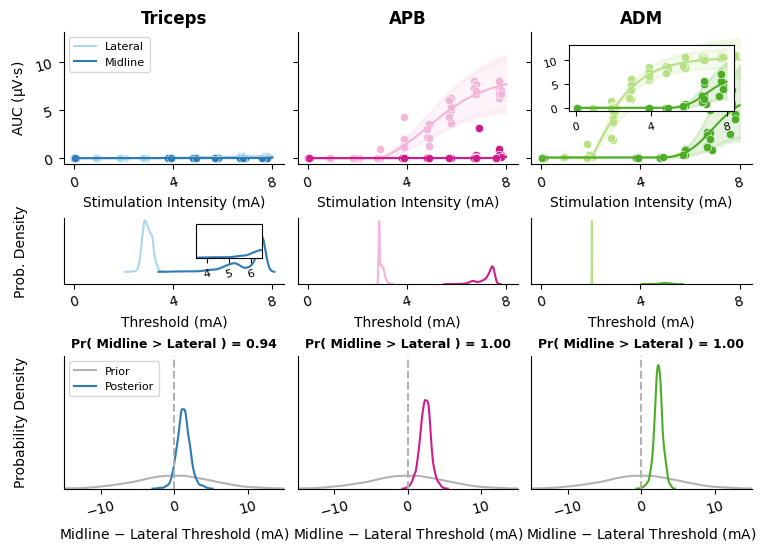

In [7]:
response = ['Triceps', 'APB', 'ADM']

""" Plot """
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1], constrained_layout=True)

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        c = (7, side)
        if side == 0: lab = "Lateral"
        if side == 1: lab = "Midline"
        color = response_colors[side][muscle_ind]

        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[0, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax, label=lab)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 0])

        ax = axes[1, muscle_ind]
        sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)
        ax.sharex(axes[0, 0])
        if muscle_ind == 0:
            ax.set_ylim(bottom=-.5)

        if (side, muscle_ind) in [(1, 0)]:
            ins = ax.inset_axes([0.6,0.4,0.3,0.5])
            sns.kdeplot(a[:, *c, muscle_ind], ax=ins, color=color)
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.set_xlim(left=3.5, right=6.5)
            ins.xaxis.set_major_locator(plt.MaxNLocator(3))
            ins.tick_params(
                axis='both',
                which='both',
                left=False,
                bottom=True,
                right=False,
                top=False,
                labelleft=False,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=8
            )

    ax = axes[2, muscle_ind]
    samples = a_random_mean[:, 0, muscle_ind]
    d = dist.Normal(0, 5)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")
    sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind], label="Posterior")
    prob = (samples > 0).mean()
    ax.set_title(f"Pr( Midline > Lateral ) = {prob:.2f}", fontweight="bold", size=9)
    ax.sharex(axes[2, 0])
    ax.sharey(axes[2, 0])
    ax.axvline(x=0, color=prior_color, linestyle="--")
    ax.set_xlim(left=-15, right=15)

ax = axes[0, 2]
ins = ax.inset_axes([0.17,0.4,0.75 ,0.5])
for side in [0, 1]:
    c = (7, side)
    color = response_colors[side][muscle_ind]

    ind = df[model.features].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True).copy()

    pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
    temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

    temp_obs = obs[:, pred_ind, muscle_ind]
    temp_mu = mu[:, pred_ind, muscle_ind]
    temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
    sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
    ins.fill_between(
        temp_pred_df[model.intensity],
        temp_obs_hpdi[0, :],
        temp_obs_hpdi[1, :],
        color=color,
        alpha=.15
    )
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_xticks([0, 4, 8])
    # ins.set_yticks([0, 0.2])
    ins.yaxis.set_major_locator(plt.MaxNLocator(3))
    ins.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=8
    )

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        ax = axes[0, muscle_ind]
        ax.set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

        ax = axes[1, muscle_ind]
        ax.set_xlabel("Threshold (mA)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

        ax = axes[2, muscle_ind]
        ax.set_xlabel("Midline $-$ Lateral Threshold (mA)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 4, 8])
ax.legend(loc="upper left", prop={'size': 8})

for j in range(1, 3):
    ax = axes[0, j]
    ax.get_legend().remove()


for j in range(3):
    ax = axes[0, j]
    ax.set_title(response[j], fontweight="bold")
    ax = axes[1, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
    )
    ax = axes[2, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
    )

ax = axes[1, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[2, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
    labelbottom=True,
    labelrotation=15
)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-10, 0, 10])
ax.set_yticks([0., 0.4, 0.8])
ax.legend(loc="upper left", prop={'size': 8})

fig.align_xlabels()
fig.align_ylabels()
# [subfig.align_ylabels() for subfig in subfigs]

dest = os.path.join(BUILD_DIR, "midline-lateral.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "midline-lateral.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
